In [7]:
import random
from Graph import Graph
#from Facades.SmartRouteMakerFacade import SmartRouteMakerFacade as srm
import math
import pandas
import numpy as np
import osmnx as ox
from networkx import MultiDiGraph
import json
from turtle import st
from typing import Tuple
from Planner import Planner
from Analyzer import Analyzer
from timeit import default_timer as timer
import srtm
import matplotlib.pyplot as plt




# self.analyzer = Analyzer.Analyzer()
# self.visualizer = Visualizer.Visualizer()
# self.graph = Graph.Graph()
# self.planner = Planner.Planner()

# "need to be deleted and implemented in huidige code"
def normalize_coordinates(coordinates: str, delimiter: str = ",") -> Tuple:
        """Converts a front-end inputted coordinate string into a tuple of two floats.

        Args:
            coordinates (str): String of two delimited coordinates
            delimiter (str, optional): The delimiter. Defaults to ",".

        Returns:
            Tuple: (x.xx, y.yy) tuple of normalized coordinates.
        """

        return tuple([float(coordinate.strip()) for coordinate in coordinates.split(delimiter)])  


    
#     # coordinates are (lat, lon)
def circuit_gen_k(graph: MultiDiGraph, start_node: int, max_length:int = 10000, i_points: int = 5, max_height:int= 150, max_incline:int = 5,max_surface:int = None, iter:int = 5):
    """"


    
    """
    elevation_data = srtm.main.get_data()
    variance = 1.1
    angle = np.linspace(0, 2*np.pi, 360) 
    direction = angle[random.randint(0,359)]
    opposite_direction = (direction + np.pi) % (2 * np.pi)
    radius = max_length / math.pi / 2
    difference_lon = math.cos(direction)* radius * variance / 111000
    difference_lat = math.sin(direction)* radius * variance / 111000
    x=float(graph.nodes[start_node]["x"]) + float(difference_lon)
    y=float(graph.nodes[start_node]["y"]) + float(difference_lat)
    center = ox.nearest_nodes(graph, x , y)

    
    circle_dpoints = i_points
    points_data = dict()
    points = []
    angle = np.linspace(0, 2*np.pi, circle_dpoints) 
    for i in angle:
        degree = opposite_direction + i
        difference_lon = math.cos(degree)* radius * variance / 111000
        difference_lat = math.sin(degree)* radius * variance / 111000
        y = float(graph.nodes[center]["y"]) + float(difference_lat)
        x = float(graph.nodes[center]["x"]) + float(difference_lon)
        
        cirkel_node = ox.nearest_nodes(graph, x, y)
        
        points_data[cirkel_node]=graph.nodes[cirkel_node]
        points.append(cirkel_node)
    
    #make route
    planner = Planner()
    analyzer = Analyzer()
    loss = float("inf")
    route_not_found = False
    for i in range(0,iter):
        change = 500
        cyclus_temp = []
        cyclus_length_temp = 0
        seperate_paths =[]
        
        if i > 0:
             distances = []
             new_points =[]
             
             for p in points:
                angle = np.linspace(0, 2*np.pi, circle_dpoints) 
                
                degree = random.choice(angle)
                difference_lon = math.cos(degree)* (change / 111000)
                difference_lat = math.sin(degree)* (change / 111000)
                y = float(graph.nodes[p]["y"]) + float(difference_lat)
                x = float(graph.nodes[p]["x"]) + float(difference_lon)

                if p == 0 or p =="0": #something happens here that i don't know how to fix
                    continue
                new_cirkel_node = ox.nearest_nodes(graph, x, y)
                new_points.append(new_cirkel_node)
                
             points = new_points
        
        
        for waypoint_start in range(0,len(points)-1):
            waypoint_end = waypoint_start+1
            #not needed because the last point is always the first because you go full circle
            if waypoint_end >= len(points):
                waypoint_end = 0
            if points[waypoint_end] == 0 or points[waypoint_end] == "0": #some BULLSHIT happens here that i don't know how to fix
                continue
            #merge the subsections
            segm = planner.shortest_path(graph,points[waypoint_start],points[waypoint_end])
            if segm == None:
                route_not_found = True
                continue
            
            for m in segm:
                # print(f"node:{m}")
                cyclus_temp.append(m)
            seperate_paths.append(segm)
            cyclus_length_temp += analyzer.shortest_path_length(graph,points[waypoint_start],points[waypoint_end])
        if route_not_found == True:
            route_not_found = False
            continue
        verhard = ["asphalt",
                    "paved",
                    "concrete",
                    "Concrete:lanes",
                    "Concrete:plates",
                    "paving",
                    "cobblestone",
                    "unhewn_cobblestone",
                    "metal",
                    "stepping_stones",
                    "compacted",
                    "rock"
                    ]
        onverhard = ["sett",
                    "grass",
                    "wood",
                    "unpaved",
                    "fine_gravel",
                    "gravel",
                    "earth",
                    "ground",
                    "dirt",
                    "soil",
                    "mud",
                    "sand",
            ]
        lengte_verhard =0
        lengte_onverhard = 0
        for path in seperate_paths:

            if True:
                route_analysis = analyzer.get_path_attributes(graph, path)
            else:
                route_analysis = None

            if True:
                surface_dist = analyzer.get_path_surface_distribution(route_analysis)
                # surface_dist_visualisation = self.visualizer.build_surface_dist_visualisation(route_analysis, graph)

                # surface_dist_legenda = {}

                # for type in surface_dist:
                #     surface_dist_legenda[type] = (self.visualizer.get_surface_color(type))
            else:
                surface_dist = None
                surface_dist_visualisation = None
                surface_dist_legenda = None
            for surfice in surface_dist:
                if surfice in verhard:
                    lengte_verhard+= surface_dist[surfice]
                elif surfice in onverhard:
                    lengte_onverhard += surface_dist[surfice]
        

        
        
        print(f"interatie: {i}")
        print(f"oude loss: {loss}")
        elevations, height_route = calculate_height(graph, cyclus_temp, elevation_data)
        new_loss,length_loss, height_loss, wegdek_loss = get_loss(route_dist = cyclus_length_temp, 
                            kms_target = max_length, 
                            height = height_route, 
                            height_target = max_height,
                            wegdekverhard= lengte_verhard,
                            wegdeknietverhard= lengte_onverhard,
                            wegdek_target= max_surface,
                            printb=True)
        print(f"nieuwe loss: {new_loss}")
        if loss > new_loss: 
            loss = new_loss
            cyclus = cyclus_temp
            cyclus_length = cyclus_length_temp
            segments_path = seperate_paths
            final_verhard = lengte_verhard
            final_onverhard = lengte_onverhard
            
        
    print(cyclus)
    print(cyclus_length)    
    return cyclus, cyclus_length, height_route, segments_path, loss, final_verhard, final_onverhard

def euclidian_distance_nodes(graph, node1, node2):
    x1 = graph._node[node1]["x"]
    y1 = graph._node[node1]["y"]
    x2 = graph._node[node2]["x"]
    y2 = graph._node[node2]["y"]
    distance = ((x2-x1)**2+(y2-y1)**2)**0.5
    return distance

def calculate_height(graph, route, elevation_data):
    route_elevations = []
    for row in route:
        elevation = elevation_data.get_elevation(graph.nodes[row]["y"],graph.nodes[row]['x'])
        # print(elevation)
        route_elevations.append(elevation)
    # print(route_elevations)
    d_plus_out = 0
    for i, val in enumerate(route_elevations[1:]):
        if val > route_elevations[i]:
            d_plus_out += val - route_elevations[i]
        # print(f'{i+1} - prec_elev: {route_elevations[i]}, elev: {val}, d+: {d_plus_out}')
    return route_elevations, d_plus_out

def get_loss(route_dist, kms_target, height = 0, height_target = 0, wegdekverhard = 0, wegdeknietverhard = 0, wegdek_target = None, printb = False):
  length_loss = abs(route_dist*1000 / kms_target - 1)
  height_loss = abs(height / height_target - 1)

  if wegdek_target == None:
      wegdek_loss = 0
  else:
      if wegdek_target > 0.5:
          wegdek_loss = abs(wegdekverhard / route_dist -1)
      else:
        wegdek_loss = abs(wegdeknietverhard / route_dist-1)  
  loss = (float(length_loss) + float(height_loss) + float(wegdek_loss))/3 # + height, surface,
  if printb == True:
      donothing = 0
    #   print(f"distance from target: {length_loss}")
    #   print(f"height from target: {height_loss}")
  return float(loss) ,length_loss, height_loss, wegdek_loss     

print("loaded")


loaded


In [20]:
#k is afstand in meter van route
k = 25000
50.88148497726243, 5.962486267089845
start_point =str(50.88148497726243)+","+str(5.962486267089845)
graph_class = Graph()

print(start_point)
start_coordinates = normalize_coordinates(start_point)
graph = Graph.full_geometry_point_graph(graph_class, start_coordinates, radius= .5*k, type="bike")
 


print(graph)
Y,X = start_coordinates
start_node = ox.nearest_nodes(graph, X, Y) 

# k_values = [3,4,5,6,7,8,9,10]
# kilometers = [5000,10000,15000,20000,25000,30000,35000,40000]
# # for i in range(0,len(kilometers)):
# #     for j in range(0,len(k_values)):
# #         start_time = timeit.default_timer()
# #         path =  circuit_gen_k(graph, start_node, kilometers[i],k_values[j])
# #         end_time = timeit.default_timer()
# #         print("kilometers = ", kilometers[i],"\naantal punten op cirkel = ", k_values[j],"\nExecution time : ", end_time -start_time)
    

# # pause = input("pause")



50.88148497726243,5.962486267089845
MultiDiGraph with 22201 nodes and 55901 edges


In [40]:
# def circuit_gen_k(graph: MultiDiGraph, start_node: int, max_length:int = 10000, i_points: int = 5, max_height:int= 150, max_incline:int = 5,max_surface:int = None, iter:int = 5):
max_length = 5000
i_points = 5
max_height = 100
max_surface = 0.8
iter = 4

elevation_data = srtm.main.get_data()
variance = 1.1
angle = np.linspace(0, 2*np.pi, 360) 
direction = angle[random.randint(0,359)]
radius = max_length / math.pi / 2
difference_lon = math.cos(direction)* radius * variance / 111000
difference_lat = math.sin(direction)* radius * variance / 111000
x=float(graph.nodes[start_node]["x"]) + float(difference_lon)
y=float(graph.nodes[start_node]["y"]) + float(difference_lat)
center = ox.nearest_nodes(graph, x , y)




circle_dpoints = i_points
points_data = dict()
points = []
angle = np.linspace(0, 2*np.pi, circle_dpoints) 
for i in angle:
    degree = i
    difference_lon = math.cos(degree)* radius * variance / 111000
    difference_lat = math.sin(degree)* radius * variance / 111000
    y = float(graph.nodes[center]["y"]) + float(difference_lat)
    x = float(graph.nodes[center]["x"]) + float(difference_lon)
    # print("x = "+ str(x))
    # print("y = " + str(y))
    cirkel_node = ox.nearest_nodes(graph, x, y)
    # print(cirkel_node)
    points_data[cirkel_node]=graph.nodes[cirkel_node]
    points.append(cirkel_node)
# print(points)

#make route
planner = Planner()
analyzer = Analyzer()
loss = float("inf")
route_not_found = False
for i in range(0,iter):
    change = 500
    cyclus_temp = []
    cyclus_length_temp = 0
    seg_length_temp = 0
    cum_length_temp = [0]
    seperate_paths =[]
    if i > 0:
            distances = []
            new_points =[]
            
            for p in points:
                angle = np.linspace(0, 2*np.pi, circle_dpoints) 
                
                degree = random.choice(angle)
                difference_lon = math.cos(degree)* (change / 111000)
                difference_lat = math.sin(degree)* (change / 111000)
                y = float(graph.nodes[p]["y"]) + float(difference_lat)
                x = float(graph.nodes[p]["x"]) + float(difference_lon)

                if p == 0 or p =="0": #something happens here that i don't know how to fix
                    continue
                new_cirkel_node = ox.nearest_nodes(graph, x, y)
                # print(f"new node: {new_cirkel_node}")
                
                # distances.append(euclidian_distance_nodes(graph, new_cirkel_node, p))
                # closest_node = min(distances)
                new_points.append(new_cirkel_node)
                # points.insert(i,new_cirkel_node)
                # points.remove(p)
                # print(points)
            points = new_points
            print(points)
    # print(f"cyclus:{i}")
    
    for waypoint_start in range(0,len(points)-1):
        # print(f"start: {waypoint_start}")
        waypoint_end = waypoint_start+1
        #not needed because the last point is always the first because you go full circle
        if waypoint_end >= len(points):
            waypoint_end = 0
        if points[waypoint_end] == 0 or points[waypoint_end] == "0": #some BULLSHIT happens here that i don't know how to fix
            continue
        #merge the subsections
        print(waypoint_start)
        print(waypoint_end)
        segm = planner.shortest_path(graph,points[waypoint_start],points[waypoint_end])
        if segm == None:
            route_not_found = True
            break
        
        for m in segm:
            # print(f"node:{m}")
            cyclus_temp.append(m)
            # seg_length_temp += graph[m]["length"]
            # cum_length_temp.append
        seperate_paths.append(planner.shortest_path(graph,points[waypoint_start],points[waypoint_end]))
        cyclus_length_temp += analyzer.shortest_path_length(graph,points[waypoint_start],points[waypoint_end])
        # cum_length_temp.append(cyclus_length_temp)

    if route_not_found == True:
        route_not_found = False
        continue
    verhard = ["asphalt",
                "paved",
                "concrete",
                "Concrete:lanes",
                "Concrete:plates",
                "paving",
                "cobblestone",
                "unhewn_cobblestone",
                "metal",
                "stepping_stones",
                "compacted",
                "rock"
                ]
    onverhard = ["sett",
                "grass",
                "wood",
                "unpaved",
                "fine_gravel",
                "gravel",
                "earth",
                "ground",
                "dirt",
                "soil",
                "mud",
                "sand",
        ]
    lengte_verhard = 0
    lengte_onverhard = 0
    for path in seperate_paths:

        if True:
            route_analysis = analyzer.get_path_attributes(graph, path)
        else:
            route_analysis = None

        if True:
            surface_dist = analyzer.get_path_surface_distribution(route_analysis)
            # surface_dist_visualisation = self.visualizer.build_surface_dist_visualisation(route_analysis, graph)

            # surface_dist_legenda = {}

            # for type in surface_dist:
            #     surface_dist_legenda[type] = (self.visualizer.get_surface_color(type))
        else:
            surface_dist = None
            surface_dist_visualisation = None
            surface_dist_legenda = None
        for surfice in surface_dist:
            if surfice in verhard:
                lengte_verhard+= surface_dist[surfice]
            elif surfice in onverhard:
                lengte_onverhard += surface_dist[surfice]
    
        print(f"oude loss: {loss}")
    elevations, height_route = calculate_height(graph, cyclus_temp, elevation_data)
    new_loss,length_loss, height_loss, wegdek_loss = get_loss(route_dist = cyclus_length_temp, 
                        kms_target = max_length, 
                        height = height_route, 
                        height_target = max_height,
                        wegdekverhard= lengte_verhard,
                        wegdeknietverhard= lengte_onverhard,
                        wegdek_target= max_surface,
                        printb=True)
    print(f"nieuwe loss: {new_loss}")
    if loss > new_loss : 
        loss = new_loss
        cyclus = cyclus_temp
        cyclus_length = cyclus_length_temp
        cum_length = cum_length_temp
        segments_path = seperate_paths
        final_verhard = lengte_verhard
        final_onverhard = lengte_onverhard
        
    
print(cyclus)
print(cyclus_length)    


0
1
[5734986002, 42049999, 42039841, 2844220705, 6271908425]
0
1
1
2
2
3
3
4
oude loss: inf
[108, 105, 107, 107, 107, 107, 107, 108, 108, 108, 109, 109, 109, 110, 111, 111, 111, 111, 111, 107, 107, 107, 107, 103, 102, 102, 104, 106, 102, 100, 100, 98, 85, 85, 86, 86, 87, 87, 87, 95, 108, 110, 111, 110, 106, 107, 107, 107, 104, 107, 99, 102, 102, 102, 102, 99, 97, 97, 102, 102, 102, 102, 101, 101, 101, 103, 103, 105, 105, 104, 104, 104, 106, 104, 105, 105, 105, 104, 104, 104, 101, 102, 99, 96, 99, 97, 97, 94, 94, 91, 97, 97, 98, 99, 99, 99, 99, 99, 100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 101, 103, 103, 104, 105, 101, 98, 98, 100, 99, 103, 104]
nieuwe loss: 0.3418298072402446
[2281193080, 42045129, 3234241861, 8778548069, 42029226]
0
1
1
2
2
3
3
4
oude loss: 0.3418298072402446
[107, 111, 110, 110, 109, 110, 110, 109, 109, 109, 110, 111, 112, 112, 112, 112, 114, 114, 111, 111, 110, 110, 111, 112, 107, 104, 107, 99, 102, 101, 101, 102, 102, 101, 101, 101, 103, 106, 106, 106, 106, 106, 

In [45]:
#remove incline
print( graph[42022446])
# for i in graph.nodes():
#     for j in graph[i]:
#         print(graph[i][j])
#         print([*graph[i][j]])
#         print(graph[i][j][0]['geometry'])
#     print([*graph[i]])

#     break

for u, v, k, data in graph.edges(keys=True, data=True):
    print(data)
    break
    if 'grade' in data:
        incline = data['grade']  # Incline is already provided in the data
        print(incline)
# for wayid, way in graph.edges(data = True):
#     if "incline" in way and way["incline"] is not None:
#         print(way["incline"])

#         print(i)
#         # print(way)


# for value in graph:
#     print(graph[vaue])
#     if "incline" in graph[value][0]:
#         print(graph[value][0]["incline"])
#     # print(graph.edges[value[0],value[1]])
#     # print(graph.ways[value])

{42022769: {0: {'osmid': 160379241, 'name': 'Julianusstraat', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': False, 'length': 92.884, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C5A03258A0>}}, 42022183: {0: {'osmid': 160379242, 'name': 'Julianusstraat', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 60.7, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C5A0324F70>}}, 42021730: {0: {'osmid': 186892287, 'name': 'Enniusstraat', 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 58.152, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C5A0325150>}}, 8786533408: {0: {'osmid': 949150556, 'highway': 'path', 'surface': 'paved', 'oneway': False, 'reversed': True, 'length': 42.964, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C5A03247C0>}}}
{'osmid': 884691519, 'name': 'Wachelderberg', 'highway': 'u

ZeroDivisionError: float division by zero

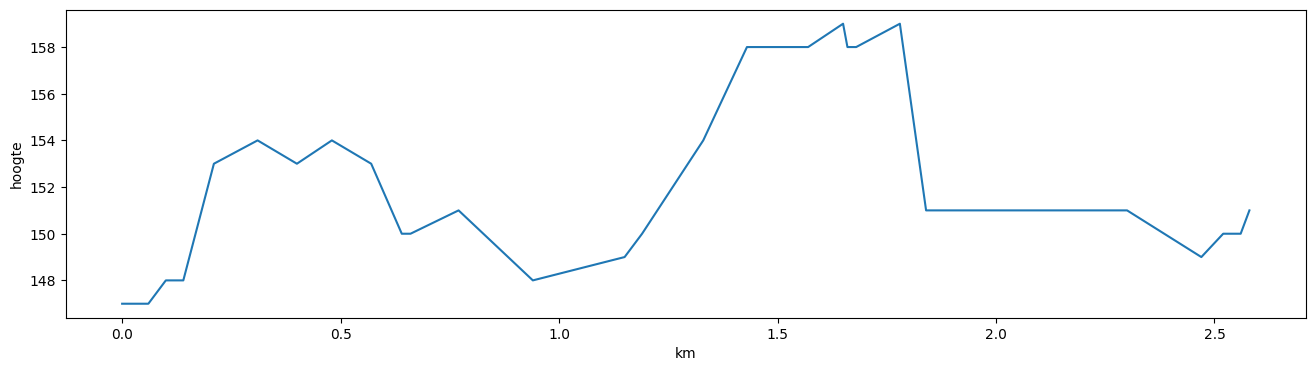

In [21]:
# route_elevations = def calculate_height(graph, path, elevation_data):
cum_length = [0]
cum_length_temp = 0
planner = Planner()
analyzer = Analyzer()
for i, way in enumerate(path):
    j = i+1
    if j>= len(path):
        break
    cum_length_temp += analyzer.shortest_path_length(graph,path[i],path[j])
    cum_length.append(cum_length_temp)

elevation_data = srtm.main.get_data()
elevations, height_route = calculate_height(graph, path, elevation_data)
# plt.plot(list(range(0,len(elevations))), elevations, marker='.')

plt.figure(figsize =(16, 4))
plt.xlabel("km")
plt.ylabel("hoogte")
plt.plot(cum_length, elevations, marker='')

incline = []
dx = []
for i, way in enumerate(path):
    j = i+1
    if j>= len(path):
        j = 0
    if path[i] == path[j]:
        delta_x = 000.1
    #delta y /delta x
    else:
        delta_x = analyzer.shortest_path_length(graph,path[i],path[j])
    dx.append(delta_x)
    incline.append((elevations[j]- elevations[i]) / (delta_x*1000))

print(incline)
print(max(incline))
print(max([abs(max(incline)),abs(min(incline))]))

In [39]:
ox.basic_stats(graph)

{'n': 4072,
 'm': 9773,
 'k_avg': 4.800098231827112,
 'edge_length_total': 623131.5290000011,
 'edge_length_avg': 63.760516627443074,
 'streets_per_node_avg': 2.8462671905697445,
 'streets_per_node_counts': {0: 0,
  1: 641,
  2: 35,
  3: 2736,
  4: 634,
  5: 21,
  6: 5},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1574165029469548,
  2: 0.008595284872298626,
  3: 0.6719056974459725,
  4: 0.1556974459724951,
  5: 0.005157170923379175,
  6: 0.0012278978388998035},
 'intersection_count': 3431,
 'street_length_total': 351583.1319999995,
 'street_segment_count': 5738,
 'street_length_avg': 61.27276612059943,
 'circuity_avg': 1.0704947393828586,
 'self_loop_proportion': 0.004879749041477867}

In [ ]:
ox.plot_graph(graph,)

RUNNING CODE

In [30]:
start = timer()
#return cyclus, cyclus_length, height_route, segments_path, loss, final_verhard, final_onverhard
path, length, height, segements, loss, verhard, onverhard =  circuit_gen_k(graph = graph,
                                      start_node= start_node,
                                      max_length = k ,
                                      i_points = 5,
                                      max_height= 150,
                                      max_surface= -1,
                                      max_incline= 10,
                                      iter = 100)
end = timer() # in seconds
print(f"start : {start} \nend: {end} \ntime elapsed: ", end - start)
# path, length =circuit_gen_k(graph, start_node, k, 4)
print("path = ", path)
print("lengte = " , length)
print("hoogte = ", height)
# print("finished")
# print("length =", end = " ")
# print(length)

# import csv

#  with open('test', 'w+', newline='') as file:
#      writer = csv.writer(file)
     
#      writer.writerow(["Gewenste Afstand", 
#                       "Gewenste Hoogte", 
#                       "Maximale Helling" ,
#                       "Percentage Verhard",
#                       "Afstand",
#                       "Hoogtemters,
#                       "percentage verhard",
#                       "score"])


interatie: 0
oude loss: inf
nieuwe loss: 0.4828888888888889
interatie: 1
oude loss: 0.4828888888888889
nieuwe loss: 0.563645574610684
interatie: 3
oude loss: 0.4828888888888889
nieuwe loss: 0.6015555555555555
interatie: 4
oude loss: 0.4828888888888889
nieuwe loss: 0.48748279252704024
interatie: 5
oude loss: 0.4828888888888889
nieuwe loss: 0.6143650793650793
interatie: 6
oude loss: 0.4828888888888889
nieuwe loss: 0.5606188145731376
interatie: 7
oude loss: 0.4828888888888889
nieuwe loss: 0.579358750519627
interatie: 8
oude loss: 0.4828888888888889
nieuwe loss: 0.5626666666666666
interatie: 9
oude loss: 0.4828888888888889
nieuwe loss: 0.6866666666666665
interatie: 10
oude loss: 0.4828888888888889
nieuwe loss: 0.816551248923342
interatie: 11
oude loss: 0.4828888888888889
nieuwe loss: 0.6913908134462408
interatie: 12
oude loss: 0.4828888888888889
nieuwe loss: 0.8595857403070518
interatie: 13
oude loss: 0.4828888888888889
nieuwe loss: 0.639088746133714
interatie: 14
oude loss: 0.482888888888

Wegdek analyze

In [ ]:
from Analyzer import Analyzer
analyzer= Analyzer()
verhard = ["asphalt",
"paved",
"concrete",
"Concrete:lanes",
"Concrete:plates",
"paving",
"cobblestone",
"unhewn_cobblestone",
"metal",
"stepping_stones",
"compacted",
"rock"
]
onverhard = ["sett",
"grass",
"wood",
"unpaved",
"fine_gravel",
"gravel",
"earth",
"ground",
"dirt",
"soil",
"mud",
"sand",
]
lengte_verhard =0
lengte_onverhard = 0
for path in segements:

    if True:
        route_analysis = analyzer.get_path_attributes(graph, path)
    else:
        route_analysis = None

    if True:
        surface_dist = analyzer.get_path_surface_distribution(route_analysis)
        # surface_dist_visualisation = self.visualizer.build_surface_dist_visualisation(route_analysis, graph)

        # surface_dist_legenda = {}

        # for type in surface_dist:
        #     surface_dist_legenda[type] = (self.visualizer.get_surface_color(type))
    else:
        surface_dist = None
        surface_dist_visualisation = None
        surface_dist_legenda = None
    for surfice in surface_dist:
        if surfice in verhard:
           lengte_verhard+= surface_dist[surfice]
        elif surfice in onverhard:
            lengte_onverhard += surface_dist[surfice]
print(lengte_onverhard)
print(lengte_verhard)
# simple_polylines = self.visualizer.extract_polylines_from_folium_map(graph, path, invert=False)


# output = {
#     "start_node": start_node,
#     "end_node": start_node,
#     "path": path,
#     "path_length": path_length,
#     "path_height": height_route,
#     "route_analysis": route_analysis,
#     "surface_dist": surface_dist,
#     "surface_dist_visualisation": surface_dist_visualisation,
#     "surface_dist_legenda": surface_dist_legenda,
#     "simple_polylines": simple_polylines
# }


Evaluation function

In [71]:
afstand = [5,10,20,30,40,60,80,100]
hoogtemeters = [100,150,300,500,800,1200,1500]
wegdek = [0.80, 0.20, None]

import csv
name = "test3.csv"
with open(name, 'w+', newline='') as file:
     writer = csv.writer(file)
     
     writer.writerow(["Gewenste Afstand", 
                      "Gewenste Hoogte", 
                      "gewenste Percentage Verhard",
                      "Afstand",
                      "Hoogtemeters",
                      "lengte verhard",
                      "lengte onverhard",
                      "score",
                      "time"])
     file.close()
for l in afstand:
   for h in hoogtemeters:
      for s in wegdek:
         try:
               
               #cyclus, cyclus_length, height_route, segments_path, loss, final_verhard, final_onverhard
            start = timer()
            path, length, height, seg, loss, final_verhard, final_onverhard =  circuit_gen_k(graph = graph,
                                                start_node= start_node,
                                                max_length = l*1000 ,
                                                i_points = 5,
                                                max_height= h,
                                                max_surface= s,

                                                iter = 5)
            end = timer() # in seconds
            with open(name, 'a+', newline='') as file:
               
               writer = csv.writer(file)
               if s == None:
                  s = -1
               writer.writerow([l, 
                                 h, 
                                 s,
                                 length,
                                 height,
                                 final_verhard,
                                 final_onverhard,
                                 loss,
                                 (end-start)])
               file.close()

         # print(f"start : {start} \nend: {end} \ntime elapsed: ", end - start)
         # # path, length =circuit_gen_k(graph, start_node, k, 4)
         # print("path = ", path)
         # print("lengte = " , length)
         # print("hoogte = ", height)
         # print("finished")
         # # print("length =", end = " ")
         # # print(length)
         except:
            with open(name, 'a+', newline='') as file:
                  
               writer = csv.writer(file)
               if s == None:
                  s = -1
               writer.writerow([l, 
                                 h, 
                                 s,
                                 -1,
                                 -1,
                                 -1,
                                 -1,
                                 -1,
                                 -1])
               file.close()



oude loss: inf
[103, 103, 101, 100, 96, 98, 97, 97, 97, 91, 97, 97, 97, 108, 106, 106, 105, 105, 105, 108, 105, 107, 109, 109, 109, 109, 109, 109, 109, 107, 107, 107, 107, 107, 107, 105, 106, 106, 106, 103, 101, 101, 101, 102, 99, 107, 107, 99, 102, 102, 102, 97, 101, 89, 89, 84, 86, 90, 87, 87, 90, 91, 91, 92, 92, 96, 100, 100, 101, 101, 102, 102, 105, 103, 103, 103]
nieuwe loss: 0.2668994018488309
oude loss: 0.2668994018488309
[110, 110, 111, 111, 111, 110, 109, 109, 108, 104, 104, 106, 106, 105, 101, 98, 98, 98, 91, 97, 97, 97, 97, 99, 96, 99, 102, 101, 104, 104, 104, 105, 105, 105, 104, 106, 104, 104, 104, 105, 105, 103, 103, 103, 101, 101, 101, 102, 99, 107, 104, 107, 107, 107, 106, 110, 111, 110, 107, 107, 110, 111, 111, 110, 107, 107, 110, 111, 110, 106, 107, 107, 107, 104, 107, 99, 102, 102, 102, 97, 101, 89, 81, 87, 89, 87, 89, 89, 94, 97, 99, 99, 99, 97, 97, 97, 102, 102, 102, 102, 102, 102, 102, 101, 101, 105, 107, 107, 120, 125, 122, 121, 121]
nieuwe loss: 0.531783715012722

In [ ]:
# route_map = ox.plot_route_folium(graph, path, route_color='#ff0000', opacity=0.5)
graph.get_edge_data(10690661621,10690661624)
# fig, ax = ox.plot_graph_route(graph,path)

Visulize route

In [34]:
#Visualizer
from IPython.display import IFrame
from Visualizer import Visualizer
def vis(graph, segements):
    vis = Visualizer()

    # vis.extract_polylines_from_folium_map(graph = graph, path= path)

    f = ox.folium.folium.Figure(width=1200, height=400)
    m = ox.folium.folium.Map()
    for seg in segements:
        rs = ox.plot_route_folium(graph,seg, route_map= m )
        f.add_child(rs)
    # for p in points:
    #     marker = ox.folium.folium.Marker(location= (graph.nodes[p]["y"],graph.nodes[p]["x"]))
    #     marker.add_to(m)
    # for i, route in enumerate(segements):
    #     rs = ox.plot_route_folium(G, route, route_map=m)
    #     f.add_child(rs)
        # ox.folium.folium.Marker(location=(G.nodes[route[-1]]['y'], G.nodes[route[-1]]['x']), popup='LeSpot', tooltip=f'{i+2}').add_to(m)
    filepath = 'route.html'
    m.save(filepath)
    
    return m
    


vis(graph, segements)

OUTPUT TO GPX

In [ ]:
import gpxpy
import gpxpy.gpx

def create_gpx_route(output_gpx_file):
    # Create a GPX object
    gpx = gpxpy.gpx.GPX()

    # Create a route
    
    route = gpxpy.gpx.GPXRoute()
    route.name = "Example Route"
    route.description = "test route "

    # Add waypoints to the route
    for seg in segements:

        for i in path:
            waypoint = gpxpy.gpx.GPXWaypoint(graph.nodes[i]["y"], graph.nodes[i]["x"])
            

            route.points.append(waypoint)

        # Add the route to the GPX object
    gpx.routes.append(route)

    # Save the GPX file
    with open("test_gpx.gpx", 'w') as f:
        f.write(gpx.to_xml())

if __name__ == "__main__":
    output_gpx_file = "example_route.gpx"
    create_gpx_route(output_gpx_file)


In [36]:

import numpy as np
import random

# Generate an array of angles between 0 and 2*pi radians (0 and 360 degrees)
angles = np.linspace(0, 2 * np.pi, 360)
print(angles)

# Select a random index from the array
random_index = random.randint(0, 359)

# Get the original direction at the random index
original_direction = angles[random_index]

# Calculate the opposite direction
opposite_direction = (original_direction + np.pi) % (2 * np.pi)

print(f"Original Direction: {np.degrees(original_direction)} degrees")
print(f"Opposite Direction: {np.degrees(opposite_direction)} degrees")

[0.         0.01750191 0.03500382 0.05250573 0.07000764 0.08750954
 0.10501145 0.12251336 0.14001527 0.15751718 0.17501909 0.192521
 0.21002291 0.22752482 0.24502673 0.26252863 0.28003054 0.29753245
 0.31503436 0.33253627 0.35003818 0.36754009 0.385042   0.40254391
 0.42004581 0.43754772 0.45504963 0.47255154 0.49005345 0.50755536
 0.52505727 0.54255918 0.56006109 0.57756299 0.5950649  0.61256681
 0.63006872 0.64757063 0.66507254 0.68257445 0.70007636 0.71757827
 0.73508018 0.75258208 0.77008399 0.7875859  0.80508781 0.82258972
 0.84009163 0.85759354 0.87509545 0.89259736 0.91009926 0.92760117
 0.94510308 0.96260499 0.9801069  0.99760881 1.01511072 1.03261263
 1.05011454 1.06761644 1.08511835 1.10262026 1.12012217 1.13762408
 1.15512599 1.1726279  1.19012981 1.20763172 1.22513363 1.24263553
 1.26013744 1.27763935 1.29514126 1.31264317 1.33014508 1.34764699
 1.3651489  1.38265081 1.40015271 1.41765462 1.43515653 1.45265844
 1.47016035 1.48766226 1.50516417 1.52266608 1.54016799 1.557669

In [ ]:
ox.nearest_nodes(graph,)
50.88148497726243, 5.962486267089845